# EDA ET Creation de reseau de neurone pour PIMA Diabetes indias
L'objectif des données est de prédire si un patient est diabétique ou non, en fonction de certaines mesures de diagnostic incluses dans l'ensemble de données.

**Grossesses**: Nombre de fois enceinte   
**Glucose**: La concentration de glucose plasmatique a 2 heures dans un test de tolérance au glucose par voie orale  
**Pression sanguine**: Tension artérielle diastolique (mm Hg)  
**SkinThickness**: Épaisseur du pli cutané des triceps (mm)  
**Insuline**: Insuline sérique 2 heures (mu U / ml)  
**IMC**: Indice de masse corporelle (poids en kg / (taille en m) ^ 2)  
**DiabetesPedigreeFunction**: Fonction pedigree du diabète  
**Âge**: Années  
**Résultat**: Variable de classe (0 ou 1)  

In [12]:
# This Python 3 environment
import gc
import os
import logging
import datetime
import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import itertools 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
#plt.style.use('seaborn-white')
#plt.style.use('seaborn')
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [13]:
# loading data in pandas df
df = pd.read_csv('pima.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [14]:
df.head(4)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0


In [15]:
diabetic=df[df['Outcome']==1]  #base de donnees des diabetic
nondiabetic=df[df['Outcome']==0] # base desnon diabetics
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

On remarque que la base de donnees  sans **valeurs manquantes**.

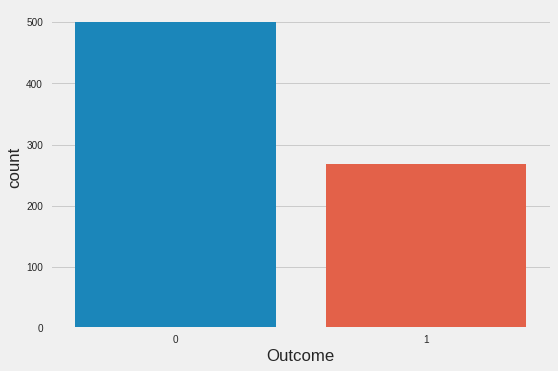

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

In [70]:
sns.countplot(x='Outcome',data=df)
plt.show()
df['Outcome'].value_counts(1)  #len(df[df.Outcome == 1])/len(df['Outcome'])

NB: Le taux de la classe 0 est largement superieur au taux de la classe 1.

Regarder sur cette lien les styles 
[Style used for plot](https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html)

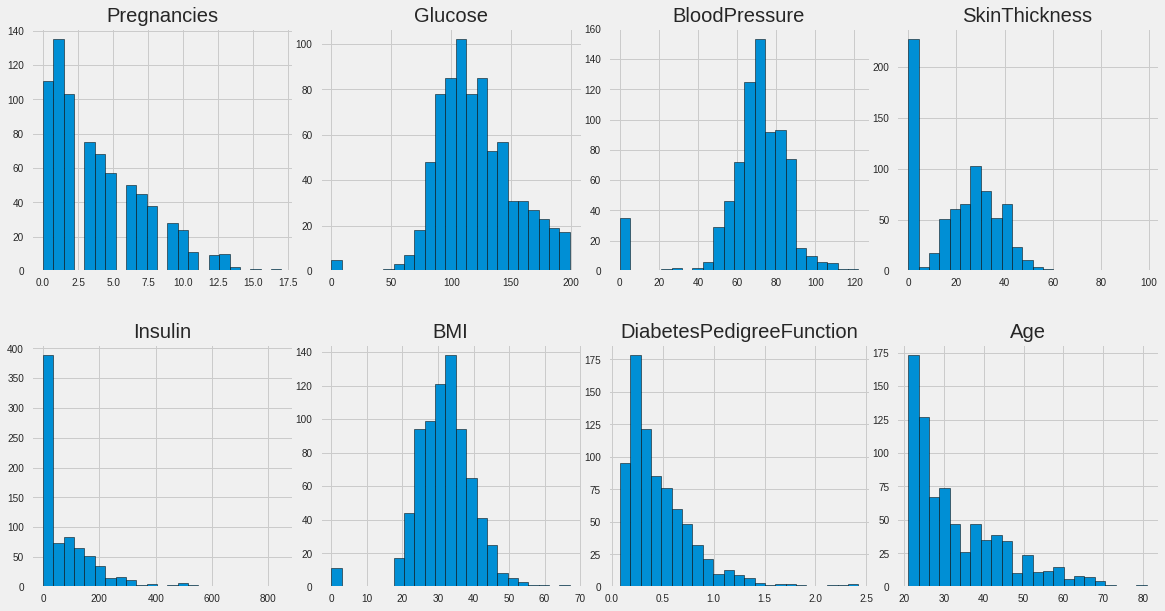

In [88]:

columns=df.columns[:8] # seul les 9 premieres colones nous intresse.
plt.subplots(figsize=(18,15))
length=len(columns)
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot(3,4,j+1)
    plt.subplots_adjust(wspace=0.1,hspace=0.3)
    df[i].hist(bins=23,edgecolor='black')
    plt.title(i)
plt.show()

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=df, hue='Outcome')

La sortie de pairplot nous permet pas de distinguer les patients diabetic ou non, nous remarquons une correlation entre SkinThicknes et BMI.

# NEURAL NETWORK

echantillonage des donnees

In [16]:
from sklearn.utils import shuffle
df1 = shuffle(df)

In [17]:
classe=df1['Outcome']
data=df1[df1.columns[:8]]
train,test=train_test_split(df1,test_size=0.2,random_state=0,stratify=df1['Outcome'])# Ech stratifie
app_X=train[train.columns[:8]]
test_X=test[test.columns[:8]]
app_Y=train['Outcome']
test_Y=test['Outcome']

### import keras et ses amis

In [18]:
import keras 
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [27]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.4):
      print("\nReached 60% accuracy so cancelling training!")
      self.model.stop_training = True

# 2. Définir le modèle

Les modèles de Keras sont définis comme une séquence de couches.  
Nous créons un modèle séquentiel et ajoutons des couches une par une jusqu'à ce que notre topologie de réseau nous satisfasse soit 12, 8, 1

In [20]:
# create m
m = Sequential()
m.add(Dense(12, input_dim=8, init='uniform', activation='relu'))
m.add(Dense(8, init='uniform', activation='relu'))
m.add(Dense(1, init='uniform', activation='sigmoid'))

In [21]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


# 3. compilation et execution du modele

Maintenant que le modèle est défini, nous pouvons le compiler.
La compilation du modèle utilise la bibliothèque numérique TensorFlow utilise come backend, il choisit automatiquement le meilleur moyen de représenter le réseau.

In [28]:
m.compile(loss='mean_squared_error' , optimizer='adam', metrics=['accuracy'])
callbacks = myCallback()
history = m.fit(app_X, app_Y, epochs=400, batch_size=len(app_X), verbose=1, callbacks=[callbacks])

Epoch 1/400
614/614 [==============================] - 0s 337us/step - loss: 0.1620 - acc: 0.7752

Reached 60% accuracy so cancelling training!


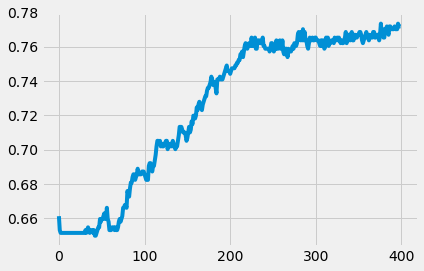

In [26]:
# plot metric  
plt.plot(history.history['acc'])
plt.show()

# evaluation du modele

In [127]:
scores = m.evaluate(app_X, app_Y)
print("\n%s: %.2f%%" % (m.metrics_names[1], scores[1]*100))

614/614 [==============================] - 0s 220us/step

acc: 78.66%


La precision de mon model est de **78%**, reste a entraine avec plus de variable et d'iteration.